In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.metrics import mean_absolute_error

In [3]:
from darts import TimeSeries
from darts.models import AutoARIMA, LightGBMModel

In [4]:
sns.set(rc={'figure.figsize':(18,10)})
sns.set(font_scale=1.25)

In [5]:
##############################################################################################################################################################################################

In [6]:
data = pd.read_csv("train.csv")

In [7]:
train = pd.DataFrame()
train["Unit"] = data["БЕ"]
train["Date"] = data["Дата транзакции"]
train["RUB"] = data["Сумма в RUB"]

In [8]:
train_0 = train[train["Unit"]==0][["Date", "RUB"]]
train_0.set_index(pd.to_datetime(train_0["Date"]), inplace=True)
train_0.drop(["Date"], inplace=True, axis=1)

train_1 = train[train["Unit"]==1][["Date", "RUB"]]
train_1.set_index(pd.to_datetime(train_1["Date"]), inplace=True)
train_1.drop(["Date"], inplace=True, axis=1)

train_2 = train[train["Unit"]==2][["Date", "RUB"]]
train_2.set_index(pd.to_datetime(train_2["Date"]), inplace=True)
train_2.drop(["Date"], inplace=True, axis=1)

train_3 = train[train["Unit"]==3][["Date", "RUB"]]
train_3.set_index(pd.to_datetime(train_3["Date"]), inplace=True)
train_3.drop(["Date"], inplace=True, axis=1)

train_4 = train[train["Unit"]==4][["Date", "RUB"]]
train_4.set_index(pd.to_datetime(train_4["Date"]), inplace=True)
train_4.drop(["Date"], inplace=True, axis=1)

train_5 = train[train["Unit"]==5][["Date", "RUB"]]
train_5.set_index(pd.to_datetime(train_5["Date"]), inplace=True)
train_5.drop(["Date"], inplace=True, axis=1)

train_6 = train[train["Unit"]==6][["Date", "RUB"]]
train_6.set_index(pd.to_datetime(train_6["Date"]), inplace=True)
train_6.drop(["Date"], inplace=True, axis=1)

In [9]:
train_6_1d = train_6.resample('1D').sum()

In [10]:
train_6_1d_reindex = train_6_1d.reset_index(inplace=False)

In [11]:
series_1d = TimeSeries.from_dataframe(train_6_1d_reindex, time_col='Date', value_cols='RUB', freq='1d', fill_missing_dates=True)

In [12]:
train_1d_split, val_1d_split = series_1d.split_before(0.80)

In [13]:
best_result = np.inf
iteration = 0
best_params = {"j": 0, "k": 0, "z": 0}
for j in range(-1, -10, -2):
    for k in range(-1, -90, -3):
        for z in range(-1, -90, -6):
            model1d = LightGBMModel(lags=[j, k, z], output_chunk_length=180)
            model1d.fit(train_1d_split)
            prediction1d = model1d.predict(len(val_1d_split))
            fixed_prediction1d = prediction1d.pd_dataframe()
            current_result = mean_absolute_error(
                val_1d_split.pd_dataframe(), prediction1d.pd_dataframe()
            )
            iteration += 1
            if iteration % 10 == 0:
                print(f"{iteration} итерация")
            if current_result < best_result:
                print(f"New best result is {current_result}  MAE")
                best_result = current_result
                best_params["j"] = j
                best_params["k"] = k
                best_params["z"] = z
                print(f"best_params is {best_params.values()}")

New best result is 447514.2087640965  MAE
best_params is dict_values([-1, -1, -1])
New best result is 438296.64895109565  MAE
best_params is dict_values([-1, -1, -25])
10 итерация
New best result is 427629.9336599906  MAE
best_params is dict_values([-1, -4, -1])
20 итерация
30 итерация
40 итерация
50 итерация
60 итерация
70 итерация
80 итерация
90 итерация
100 итерация
110 итерация
New best result is 422852.73058813356  MAE
best_params is dict_values([-1, -22, -25])
120 итерация
130 итерация
140 итерация
150 итерация
160 итерация
170 итерация
180 итерация
190 итерация
200 итерация
210 итерация
220 итерация
New best result is 391296.32496042375  MAE
best_params is dict_values([-1, -46, -1])
230 итерация
New best result is 381964.2238385526  MAE
best_params is dict_values([-1, -46, -73])
240 итерация
250 итерация
260 итерация
270 итерация
280 итерация
290 итерация
300 итерация
310 итерация
320 итерация
330 итерация
340 итерация
350 итерация
360 итерация
370 итерация
380 итерация
390 итер

In [14]:
best_params

{'j': -9, 'k': -88, 'z': -79}

In [15]:
#fit, predict
model1d = LightGBMModel(lags=[-3, -79, -88], output_chunk_length=180)
model1d.fit(train_1d_split)
prediction1d = model1d.predict(len(val_1d_split))

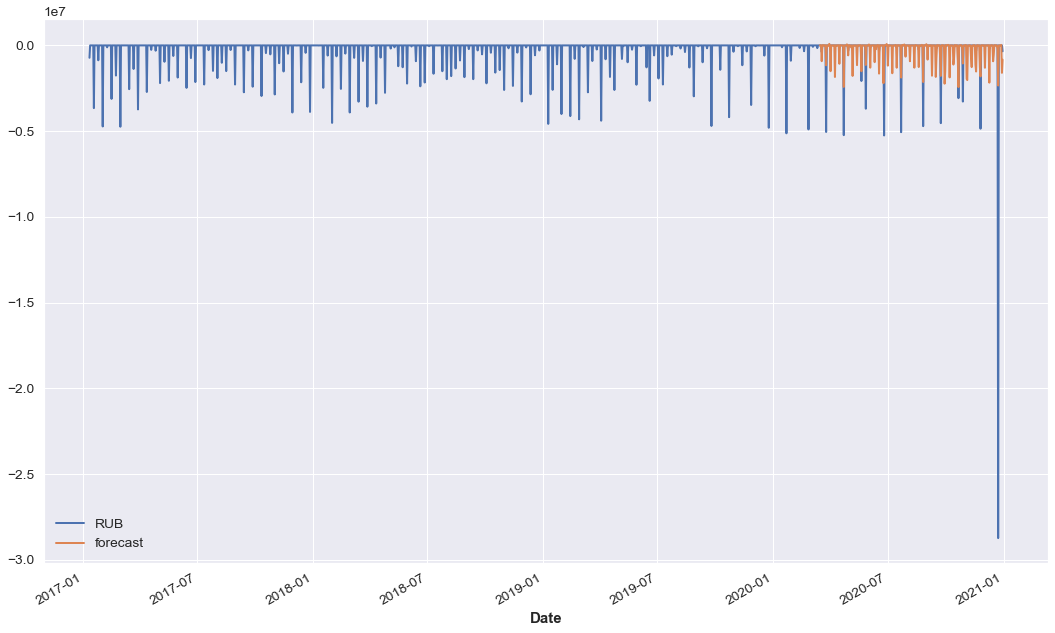

In [16]:
series_1d.plot()
prediction1d.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
plt.legend()

In [17]:
fixed_prediction1d = prediction1d.pd_dataframe()
mean_absolute_error(val_1d_split.pd_dataframe(), prediction1d.pd_dataframe())

375882.3913325187

In [18]:
fixed_prediction1d[fixed_prediction1d["RUB"]>0] = 0

In [19]:
mean_absolute_error(val_1d_split.pd_dataframe(), fixed_prediction1d)

371767.66272017354

<AxesSubplot:xlabel='Date'>

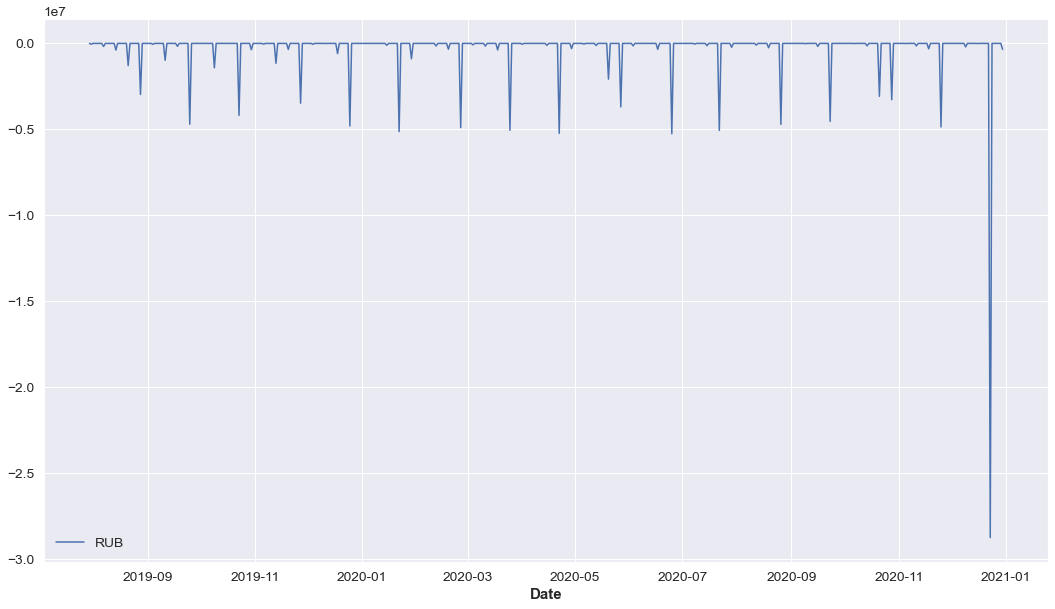

In [12]:
sns.lineplot(data=train_6_1d.loc["2019-07-30":])

In [13]:
# Пик на графике значительно выбивается, таких близко нет. Какое-то событие под конец года.
train_6_1d.loc["2019-07-30":].nsmallest(5, columns="RUB")

,RUB
Date,
2020-12-23,-2.872760e+07
2020-06-25,-5.251461e+06
2020-04-22,-5.232984e+06
2020-01-22,-5.126176e+06
2020-07-22,-5.059332e+06


In [14]:
# Последний выброс у конца года попробуем заменить на более логичное значение для более устойчивого обучения модели.

In [26]:
train_6_1d_2 = train_6_1d

In [27]:
train_6_1d_2.sort_values(by="RUB").iloc[1:6].values

array([[-5232983.89171974],
       [-5143743.22420382],
       [-5126175.96815287],
       [-5059332.08280255],
       [-5048762.68789809]])

In [28]:
train_6_1d_2.loc["2020-12-23"] = np.mean(train_6_1d_2.sort_values(by="RUB").iloc[1:6].values)

In [29]:
train_6_1d_2_reindex = train_6_1d_2.loc["2019-07-30":].reset_index()

In [30]:
series_1d_2 = TimeSeries.from_dataframe(train_6_1d_2_reindex, time_col='Date', value_cols='RUB', freq='1d', fill_missing_dates=True)

In [31]:
train_1d_2_split, val_1d_2_split = series_1d_2.split_before(0.80)

In [54]:
best_result_2 = np.inf
iteration_2 = 0
best_params_2 = {"j": 0, "k": 0, "z": 0}
for j in range(-1, -10, -2):
    for k in range(-1, -90, -3):
        for z in range(-1, -90, -6):
            model1d_2 = LightGBMModel(lags=[j, k, z], output_chunk_length=180)
            model1d_2.fit(train_1d_2_split)
            prediction1d_2 = model1d_2.predict(len(val_1d_2_split))
            fixed_prediction1d_2 = prediction1d_2.pd_dataframe()
            current_result_2 = mean_absolute_error(
                val_1d_2_split.pd_dataframe(), prediction1d_2.pd_dataframe()
            )
            iteration_2 += 1
            if iteration_2 % 10 == 0:
                print(f"{iteration_2} итерация")
            if current_result_2 < best_result_2:
                print(f"New best result is {current_result_2}  MAE")
                best_result_2 = current_result_2
                best_params_2["j"] = j
                best_params_2["k"] = k
                best_params_2["z"] = z
                print(f"best_params is {best_params_2.values()}")

New best result is 241887.1808607794  MAE
best_params is dict_values([-1, -1, -1])
New best result is 241704.43602178813  MAE
best_params is dict_values([-1, -1, -7])
New best result is 237218.9875603378  MAE
best_params is dict_values([-1, -1, -13])
New best result is 231690.77860983592  MAE
best_params is dict_values([-1, -1, -19])
10 итерация
New best result is 231530.3505701316  MAE
best_params is dict_values([-1, -4, -19])
20 итерация
30 итерация
40 итерация
50 итерация
60 итерация
New best result is 230430.39159907022  MAE
best_params is dict_values([-1, -13, -19])
70 итерация
80 итерация
90 итерация
100 итерация
110 итерация
New best result is 229494.19859593897  MAE
best_params is dict_values([-1, -22, -43])
120 итерация
130 итерация
140 итерация
150 итерация
160 итерация
170 итерация
180 итерация
190 итерация
200 итерация
210 итерация
220 итерация
230 итерация
240 итерация
250 итерация
260 итерация
270 итерация
280 итерация
290 итерация
300 итерация
310 итерация
320 итерация
3

In [ ]:
#best_params_2={'j': -9, 'k': -22, 'z': -25} # MAE 371767.66272017354
best_params_2

In [32]:
#fit, predict
model1d_2 = LightGBMModel(lags=[-9, -22, -25], output_chunk_length=180)
model1d_2.fit(train_1d_2_split)
prediction1d_2 = model1d_2.predict(len(val_1d_2_split))

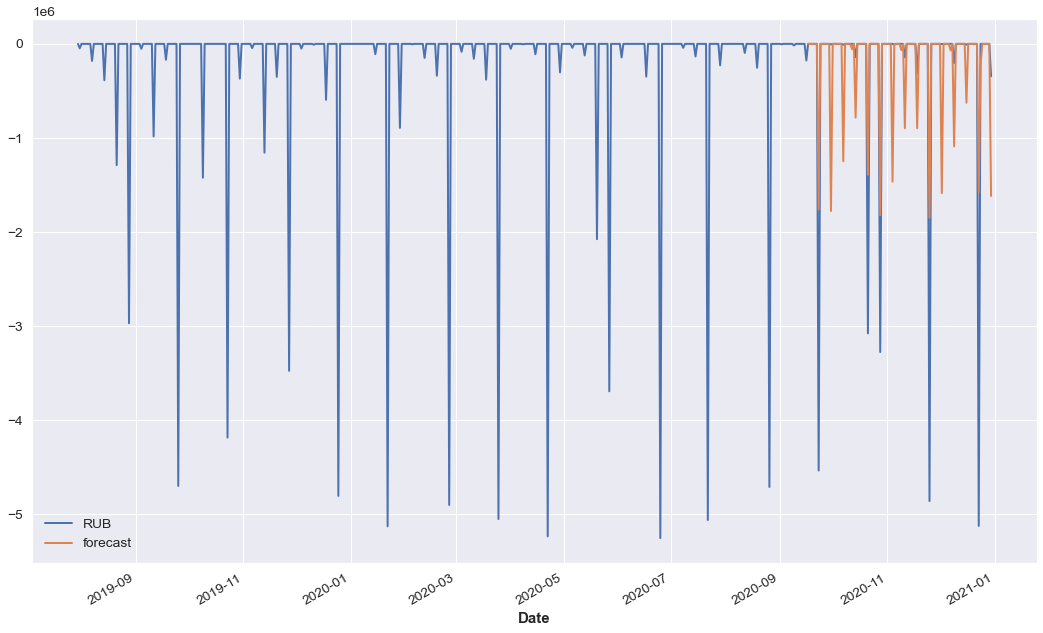

In [33]:
# Отрисовка для LightGBM, тут на глаз видно, что есть вылеты за 0 в положительную сторону, их принудительно обнуляем, т.к. (если правильно понял) у нас транзакции все в одну сторону
series_1d_2.plot()
prediction1d_2.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
plt.legend()

In [34]:
fixed_prediction1d_2 = prediction1d_2.pd_dataframe()
mean_absolute_error(val_1d_2_split.pd_dataframe(), prediction1d_2.pd_dataframe())

225776.0896177065

In [35]:
# AUTOArima 

In [36]:
train_6_7d = train_6.reset_index().groupby(pd.Grouper(key='Date', freq='7D', how='sum', closed='left')).sum()

In [37]:
train_6_7d_reindex = train_6_7d.loc["2019-07-30":].reset_index()

In [38]:
series_7d = TimeSeries.from_dataframe(train_6_7d_reindex, time_col='Date', value_cols='RUB', freq='7d', fill_missing_dates=True)

In [39]:
train_7d_split, val_7d_split = series_7d.split_before(0.80)

In [40]:
model7d = AutoARIMA()
model7d.fit(train_7d_split)
prediction7d = model7d.predict(len(val_7d_split))

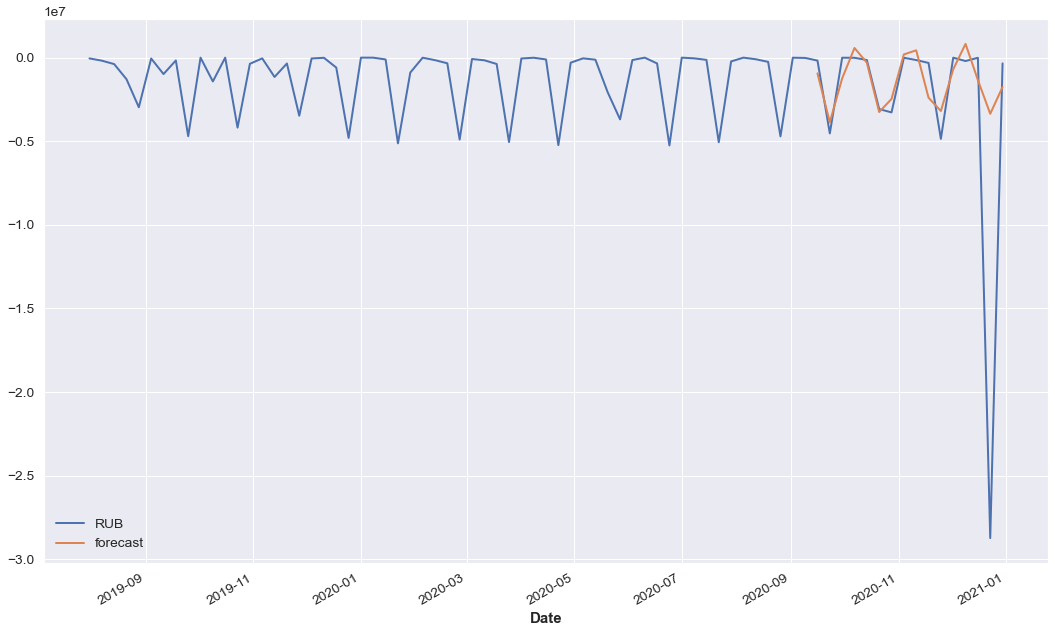

In [41]:
series_7d.plot()
prediction7d.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
plt.legend()

In [42]:
# НЕ CUMSUM
fixed_prediction7d = prediction7d.pd_dataframe()
mean_absolute_error(val_7d_split.pd_dataframe(), prediction7d.pd_dataframe())

2421878.569686071

In [43]:
fixed_prediction7d[fixed_prediction7d["RUB"]>0] = 0
mean_absolute_error(val_7d_split.pd_dataframe(), fixed_prediction7d)

2295190.303515296

In [44]:
fixed_prediction1d_2

component,RUB
Date,
2020-09-17,-4.716323e+00
2020-09-18,-4.717804e+01
2020-09-19,-4.716323e+00
2020-09-20,-4.716323e+00
2020-09-21,-7.271469e+00
...,...
2020-12-26,-5.038482e+00
2020-12-27,-5.038482e+00
2020-12-28,-1.388313e+02


In [45]:
fixed_prediction7d.resample("1D").sum().loc["2020-09-17":]

component,RUB
Date,
2020-09-17,0.000000e+00
2020-09-18,0.000000e+00
2020-09-19,0.000000e+00
2020-09-20,0.000000e+00
2020-09-21,0.000000e+00
...,...
2020-12-26,0.000000e+00
2020-12-27,0.000000e+00
2020-12-28,0.000000e+00


In [46]:
mean_absolute_error(val_1d_2_split.pd_dataframe(), ((fixed_prediction1d_2["RUB"] + fixed_prediction7d.resample("1D").sum().loc["2020-09-17":]["RUB"])/1.5).fillna(0))

160032.63246820334

In [47]:
# График для val и predict

In [48]:
predict_series = ((fixed_prediction1d_2["RUB"] + fixed_prediction7d.resample("1D").sum().loc["2020-09-17":]["RUB"])/1.5).fillna(0)

In [49]:
val_df = pd.DataFrame()
val_df.index = predict_series.index
val_df["y"] = train_6_1d_2
val_df["yhat"] = predict_series

<AxesSubplot:xlabel='Date'>

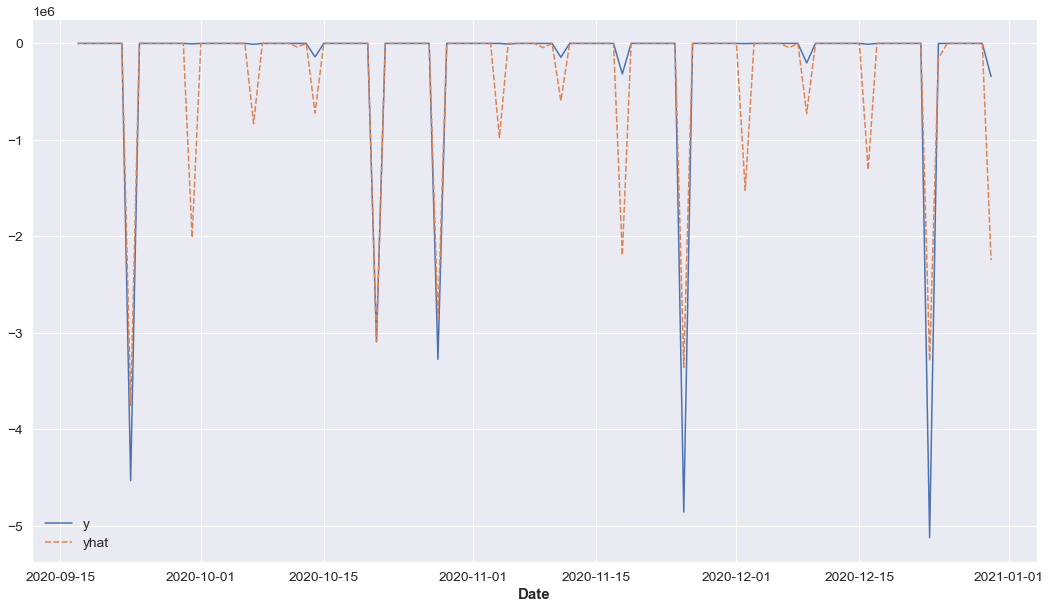

In [50]:
sns.lineplot(data=val_df)

In [51]:
# Делаем refit на полных данных для LightGBM
refit_model1d_2 = LightGBMModel(lags=[-9, -22, -25], output_chunk_length=180)
refit_model1d_2.fit(series_1d_2)
refit_prediction1d_2 = refit_model1d_2.predict(len(pd.date_range(start="2021-01-01", end="2021-06-30", freq="1D"))+1)

In [52]:
refit_prediction1d_2.pd_dataframe()

component,RUB
Date,
2020-12-31,-64013.626493
2021-01-01,-5.034236
2021-01-02,-5.034236
2021-01-03,-5.034236
2021-01-04,-16.267312
...,...
2021-06-26,-5.102142
2021-06-27,-5.102142
2021-06-28,-415.599547


In [53]:
# Предикт с разрешением в 1 день
refit_fixed_prediction1d_2 = refit_prediction1d_2.pd_dataframe()
refit_fixed_prediction1d_2[refit_fixed_prediction1d_2["RUB"]>0] = 0
refit_fixed_prediction1d_2 = refit_fixed_prediction1d_2.iloc[1:]

In [54]:
refit_fixed_prediction1d_2["RUB"]

Date
2021-01-01     -5.034236
2021-01-02     -5.034236
2021-01-03     -5.034236
2021-01-04    -16.267312
2021-01-05     -4.788262
                 ...    
2021-06-26     -5.102142
2021-06-27     -5.102142
2021-06-28   -415.599547
2021-06-29     -5.034236
2021-06-30    -76.856554
Freq: D, Name: RUB, Length: 181, dtype: float64

In [55]:
model7d.fit(series_7d)
refit_prediction7d = model7d.predict(len(pd.date_range(start="2021-01-01", end="2021-06-30", freq="1D"))+1)

In [56]:
refit_fixed_prediction7d = refit_prediction7d.pd_dataframe() # Принимаем форму стандартного датафрейма
refit_fixed_prediction7d[refit_fixed_prediction7d["RUB"]>0] = 0 # Ручная правка положительных значений

In [57]:
train_6_ans = pd.DataFrame()
#train_1_ans["Дата транзакции"] = pd.date_range(start="2021-01-05", end="2021-06-29", freq="7D") # legacy version
train_6_ans["Дата транзакции"] = pd.date_range(start="2021-01-01", end="2021-06-30", freq="1D")
train_6_ans["Сумма в RUB"] = pd.merge(train_6_ans, refit_fixed_prediction7d, how='outer', left_on=train_6_ans["Дата транзакции"], right_on=refit_fixed_prediction7d.index)["RUB"].fillna(0)
train_6_ans["Сумма в RUB"] += refit_fixed_prediction1d_2["RUB"].values
train_6_ans["Сумма в RUB"] /= 1.50
train_6_ans["Сумма в RUB"] = train_6_ans["Сумма в RUB"].groupby(train_6_ans["Дата транзакции"].dt.month).cumsum().values

train_6_ans["Месяц"] = train_6_ans["Дата транзакции"].dt.month
train_6_ans["БЕ"] = 6


In [59]:
train_6_ans.to_csv("train_6_ans.csv")